## Brain Tumor Detection


<a id="section-one"></a>
##  Classification

In [3]:
import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def importing_data(path):
    sample = [] 
    for filename in glob.glob(path): 
        sample.append(filename)
    return sample

path1 = '/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Learning/BrainTumorDetection/no/*.jpg' #data of healthy brain 
path2 = '/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Learning/BrainTumorDetection/yes/*.jpg' #brain with tumour 
path3 = '/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Learning/BrainTumorDetection/pred/*.jpg' #testing file of the images

train_n = importing_data(path1)
train_y = importing_data(path2)
test = importing_data(path3)


df_train_n = pd.DataFrame({'image':train_n, 'label': 'Healthy'})
df_train_y = pd.DataFrame({'image':train_y, 'label': 'Affected'})
df_test = pd.DataFrame({'image':test})
train_data = pd.concat([df_train_n, df_train_y])
train_data

,image,label
0,/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Lea...,Healthy
1,/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Lea...,Healthy
2,/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Lea...,Healthy
3,/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Lea...,Healthy
4,/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Lea...,Healthy
...,...,...
1495,/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Lea...,Affected
1496,/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Lea...,Affected
1497,/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Lea...,Affected
1498,/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Lea...,Affected


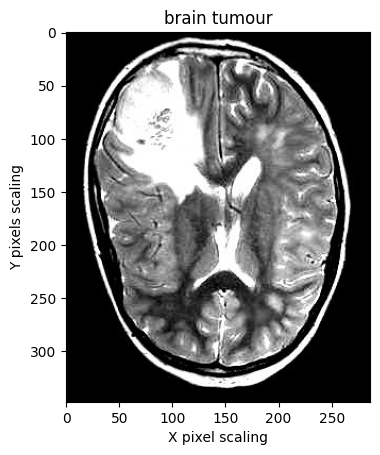

In [6]:
#a visualzation sample of the cancerous image 

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
 
plt.title("brain tumour")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
 
image = mpimg.imread("/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Learning/BrainTumorDetection/yes/y0.jpg")
plt.imshow(image)
plt.show()

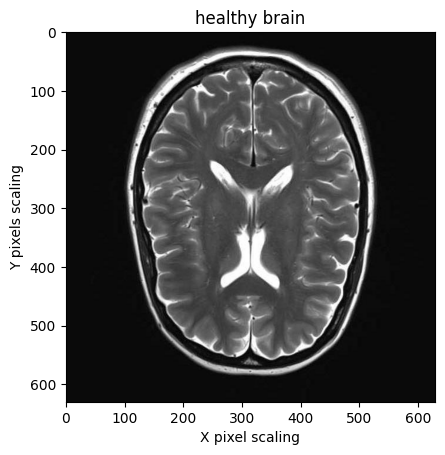

In [7]:
#a visualzation sample of a non cancerous image 

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
 
plt.title("healthy brain")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
 
image = mpimg.imread("/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Learning/BrainTumorDetection/no/No12.jpg")
plt.imshow(image)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_data,
                                  test_size = 0.1,
                                  shuffle = True,
                                  random_state = 42)

<a id="subsection-one"></a>
### CREATING THE CNN MODEL

In [9]:
import keras
from keras.metrics import AUC, Recall, Precision
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D , MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop

def build_model():
    
    '''Sequential Model creation'''
    Cnn = Sequential()
    
    Cnn.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
                   strides=(2,2), input_shape = [224,224,1]))
    Cnn.add(MaxPooling2D(2))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(MaxPooling2D(2))
    #Cnn.add(GlobalAveragePooling2D())
    Cnn.add(Flatten()) #from 2d image to 1d image to make the prediction more better
    Cnn.add(Dense(64, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(32, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(2, activation = 'softmax'))
    
    return Cnn

keras_model = build_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 256)         0         
 g2D)                                                   

In [11]:


def Model_fit(train_data, val_data):
    
    keras_model = None
    
    keras_model = build_model()
    
    '''Compiling the model'''
    
    keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics =['acc'])
    
    es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=2,
                       restore_best_weights=True,
                       verbose=1)
                       
    
    checkpoint_cb = ModelCheckpoint("Brain_model_best.h5",
                                    save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 3,
                                  min_lr = 1e-5,
                                  mode = 'min',
                                  verbose=1)
                                  
    
    history = keras_model.fit(train_data,
                              validation_data = val_data,
                              epochs= 50,
                              batch_size = 10,
                              callbacks=[es, checkpoint_cb, reduce_lr])
                              
    
      
    return history

In [12]:
#training of the model
from keras.preprocessing.image import ImageDataGenerator

k_fold = 3
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2

def CV_training(train_data, val_data):
    
    cv_histories = []
    
    for i in range(0,k_fold):
    
        datagen = ImageDataGenerator(rescale = 1./255)
    
        train_set = datagen.flow_from_dataframe(train_data,
                                                directory = '/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Learning/BrainTumorDetection/*.jpg',
                                                x_col = 'image',
                                                y_col = 'label',
                                                target_size = size,
                                                color_mode = 'grayscale',
                                                class_mode = 'sparse',
                                                batch_size = 10,
                                                shuffle = True,
                                                interpolation = 'bilinear')
        
        val_set = datagen.flow_from_dataframe(val_data,
                                              directory = '/Users/arthjani/Desktop/Arth/Study/Aa/Deep-Learning/BrainTumorDetection/*.jpg',
                                              x_col = 'image',
                                              y_col = 'label',
                                              target_size = size,
                                              color_mode = 'grayscale',
                                              class_mode = 'sparse',
                                              batch_size = 10,
                                              shuffle = True,
                                              interpolation = 'bilinear')
        print("Training on Fold: ",i+1)
    
        cv_histories.append(Model_fit(train_set, val_set))
    
    return cv_histories

cv_results = CV_training(X_train,X_val)

Found 2700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


Training on Fold:  1
Epoch 1/50
270/270 [==============================] - 30s 110ms/step - loss: 0.6303 - acc: 0.6426 - val_loss: 0.5439 - val_acc: 0.7633 - lr: 1.0000e-04
Epoch 2/50


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


270/270 [==============================] - 27s 101ms/step - loss: 0.5312 - acc: 0.7356 - val_loss: 0.4816 - val_acc: 0.7833 - lr: 1.0000e-04
Epoch 3/50
270/270 [==============================] - 31s 115ms/step - loss: 0.4510 - acc: 0.7911 - val_loss: 0.3680 - val_acc: 0.8500 - lr: 1.0000e-04
Epoch 4/50
270/270 [==============================] - 29s 107ms/step - loss: 0.3502 - acc: 0.8619 - val_loss: 0.2589 - val_acc: 0.9100 - lr: 1.0000e-04
Epoch 5/50
270/270 [==============================] - 29s 106ms/step - loss: 0.2678 - acc: 0.8989 - val_loss: 0.2114 - val_acc: 0.9267 - lr: 1.0000e-04
Epoch 6/50
270/270 [==============================] - 30s 112ms/step - loss: 0.2030 - acc: 0.9274 - val_loss: 0.2020 - val_acc: 0.9300 - lr: 1.0000e-04
Epoch 7/50
270/270 [==============================] - 39s 145ms/step - loss: 0.1389 - acc: 0.9604 - val_loss: 0.1447 - val_acc: 0.9533 - lr: 1.0000e-04
Epoch 8/50
270/270 [==============================] - 47s 174ms/step - loss: 0.1026 - acc: 0.9719 -

Epoch 1/50
270/270 [==============================] - 39s 142ms/step - loss: 0.6459 - acc: 0.6281 - val_loss: 0.5401 - val_acc: 0.7533 - lr: 1.0000e-04
Epoch 2/50


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


270/270 [==============================] - 34s 125ms/step - loss: 0.5453 - acc: 0.7489 - val_loss: 0.4801 - val_acc: 0.7833 - lr: 1.0000e-04
Epoch 3/50
270/270 [==============================] - 32s 120ms/step - loss: 0.4639 - acc: 0.7993 - val_loss: 0.3753 - val_acc: 0.8367 - lr: 1.0000e-04
Epoch 4/50
270/270 [==============================] - 34s 127ms/step - loss: 0.3624 - acc: 0.8522 - val_loss: 0.2314 - val_acc: 0.9133 - lr: 1.0000e-04
Epoch 5/50
270/270 [==============================] - 45s 167ms/step - loss: 0.2381 - acc: 0.9104 - val_loss: 0.1484 - val_acc: 0.9400 - lr: 1.0000e-04
Epoch 6/50
270/270 [==============================] - 37s 137ms/step - loss: 0.1668 - acc: 0.9419 - val_loss: 0.1482 - val_acc: 0.9567 - lr: 1.0000e-04
Epoch 7/50
270/270 [==============================] - 40s 148ms/step - loss: 0.1040 - acc: 0.9670 - val_loss: 0.0680 - val_acc: 0.9767 - lr: 1.0000e-04
Epoch 8/50
270/270 [==============================] - 40s 149ms/step - loss: 0.0700 - acc: 0.9837 -

Training on Fold:  3
Epoch 1/50
270/270 [==============================] - 49s 178ms/step - loss: 0.6497 - acc: 0.6267 - val_loss: 0.5469 - val_acc: 0.7533 - lr: 1.0000e-04
Epoch 2/50


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


270/270 [==============================] - 48s 176ms/step - loss: 0.5649 - acc: 0.7411 - val_loss: 0.4768 - val_acc: 0.7700 - lr: 1.0000e-04
Epoch 3/50
270/270 [==============================] - 46s 170ms/step - loss: 0.5008 - acc: 0.7722 - val_loss: 0.3868 - val_acc: 0.8400 - lr: 1.0000e-04
Epoch 4/50
270/270 [==============================] - 47s 173ms/step - loss: 0.4090 - acc: 0.8248 - val_loss: 0.2818 - val_acc: 0.8767 - lr: 1.0000e-04
Epoch 5/50
270/270 [==============================] - 49s 181ms/step - loss: 0.3132 - acc: 0.8744 - val_loss: 0.2061 - val_acc: 0.9400 - lr: 1.0000e-04
Epoch 6/50
270/270 [==============================] - 47s 173ms/step - loss: 0.2124 - acc: 0.9230 - val_loss: 0.1578 - val_acc: 0.9500 - lr: 1.0000e-04
Epoch 7/50
270/270 [==============================] - 60s 222ms/step - loss: 0.1431 - acc: 0.9519 - val_loss: 0.1625 - val_acc: 0.9233 - lr: 1.0000e-04
Epoch 8/50
270/270 [==============================] - 71s 264ms/step - loss: 0.0960 - acc: 0.9704 -

In [13]:
def acc_results(results):
    i = 0
    for fold in cv_results:
        print('Val_Acc Folder '+ str(i) + ' =', max(fold.history['val_acc']))
        i += 1
        
acc_results(cv_results)

Val_Acc Folder 0 = 0.9800000190734863
Val_Acc Folder 1 = 0.9900000095367432
Val_Acc Folder 2 = 0.9933333396911621


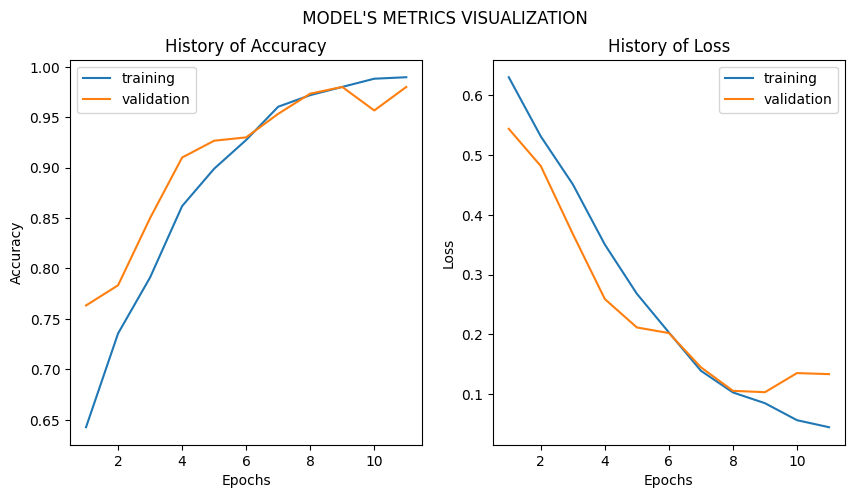

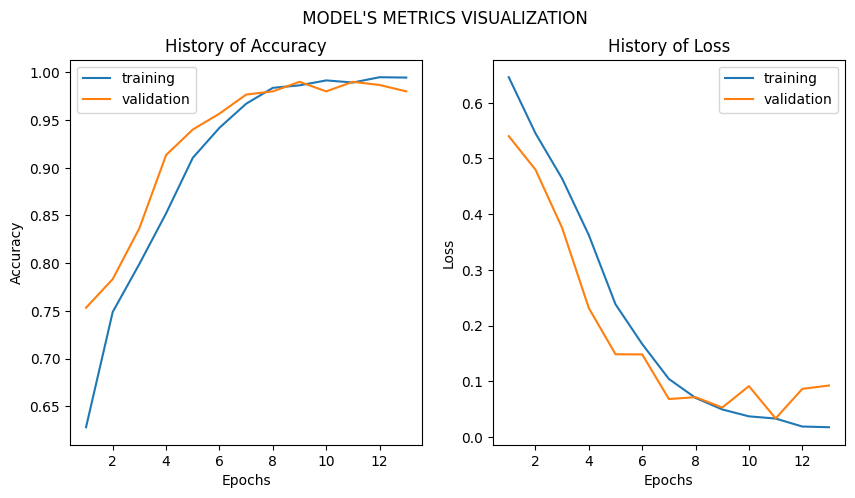

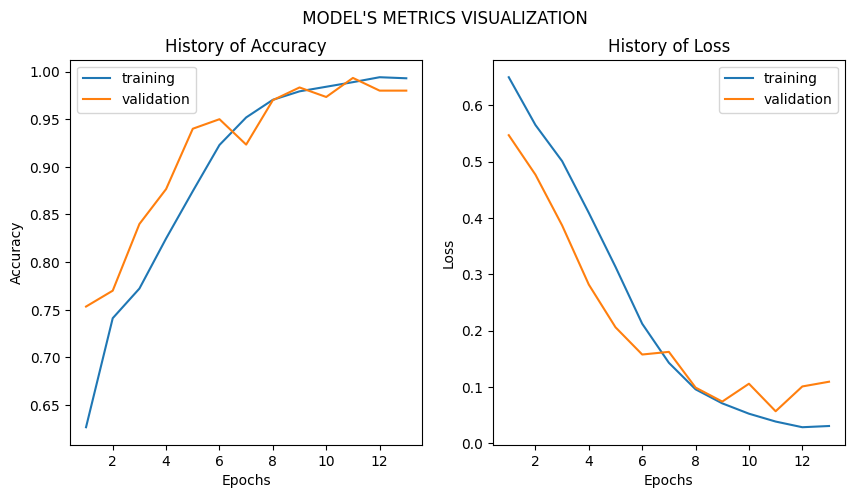

In [14]:
def Acc_Loss_Plot(results):
    
    for fold in results:
        
        acc = fold.history['acc']
        val_acc = fold.history['val_acc']
        loss = fold.history['loss']
        val_loss = fold.history['val_loss']
    
        fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))
        fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

        ax1.plot(range(1, len(acc) + 1), acc)
        ax1.plot(range(1, len(val_acc) + 1), val_acc)
        ax1.set_title('History of Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend(['training', 'validation'])


        ax2.plot(range(1, len(loss) + 1), loss)
        ax2.plot(range(1, len(val_loss) + 1), val_loss)
        ax2.set_title('History of Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend(['training', 'validation'])
        plt.show()
    
Acc_Loss_Plot(cv_results)

In [15]:
import keras

keras_model = keras.models.load_model('Brain_model_best.h5')
keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                    loss='sparse_categorical_crossentropy', metrics =[ 'acc'])

# Predictions on the test set

datagen = ImageDataGenerator(rescale = 1./255)

test_set = datagen.flow_from_dataframe(df_test,
                                       directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                       x_col = 'image',
                                       y_col = None,
                                       target_size = size,
                                       color_mode = 'grayscale',
                                       class_mode = None,
                                       batch_size = 10,
                                       shuffle = False,
                                       interpolation = 'bilinear')

predictions = keras_model.predict(test_set)
predictions = predictions.argmax(axis=-1)
print("Where 0 = 'Affected'")
print("Where 1 = 'Healthy'")
print(predictions)


Found 60 validated image filenames.
6/6 [==============================] - 1s 32ms/step
Where 0 = 'Affected'
Where 1 = 'Healthy'
[1 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1
 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1]


In [16]:
pred = []
[pred.append('Healthy') if i == 1 else pred.append('Affected') for i in predictions]
print(pred)

['Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy']


In [17]:
images10 = [test_set[0][0],test_set[0][1],test_set[0][2],test_set[0][3],test_set[0][4],
            test_set[0][5],test_set[0][6],test_set[0][7],test_set[0][8],test_set[0][9]]
            
prediction10 = pred[0:9]
final_pred = zip(images10,prediction10)

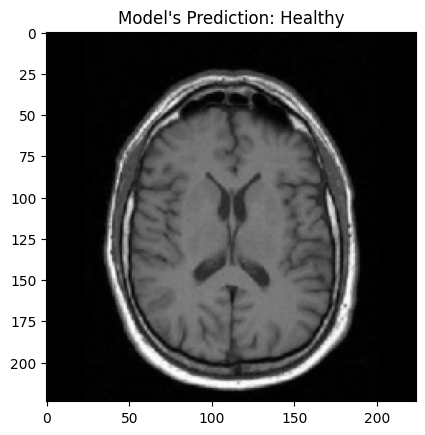

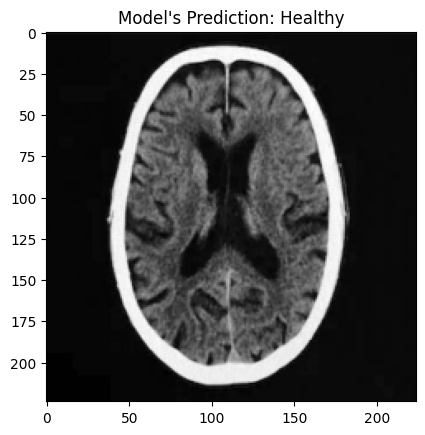

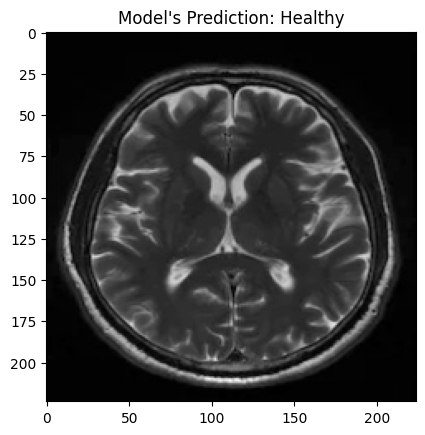

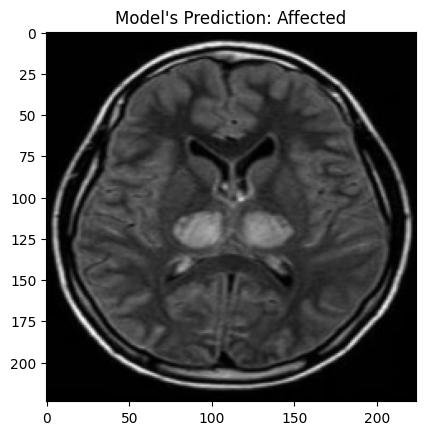

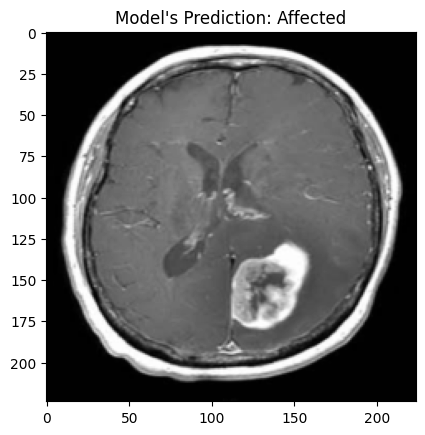

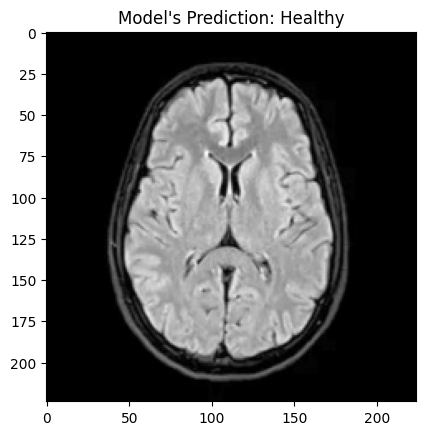

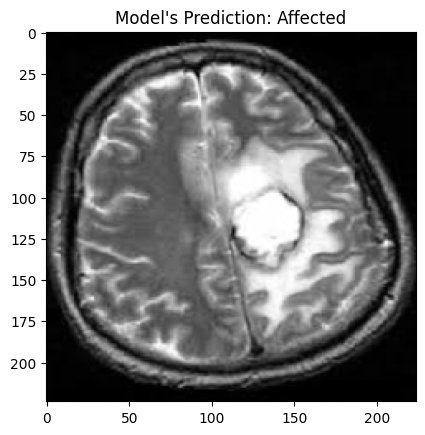

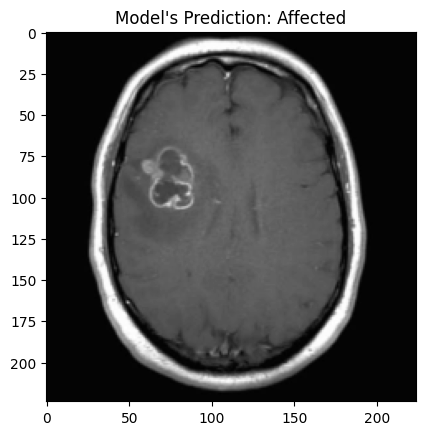

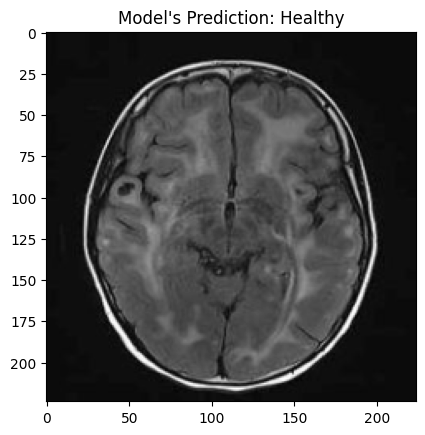

In [18]:
def pre_visualization(data, predictions):
    
    for image,pred in final_pred:
        plt.imshow(image.reshape(224,224), cmap = 'gray')
        plt.title("Model's Prediction: " + str(pred))
        plt.show()
        
pre_visualization(images10,prediction10)